# Regression example using TabSRALinear: *Synthetic* 3 dataset


   $$y  = (5x_1-5x_2)1_{x_5\le 0}+(5x_3-5x_4)1_{x_5> 0}$$




## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
sys.path.append('../')
from SRAModels import TabSRALinear,LR
from utils import TrainRegressionModel,reset_seed_,Predict, load, save,LinearScaling


## Data

In [6]:
np.random.seed(42)
x1 = np.random.normal(0,1,3*10000)
x2 = np.random.normal(0,1,3*10000)
x3 = np.random.normal(0,1,3*10000)
x4 = np.random.normal(0,1,3*10000)
x5 = np.random.normal(0,1,3*10000)
X = np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1)  ),axis=1)

In [7]:
odd = (5*x1-5*x2)*(x5<=0) + (5*x3-5*x4)*(x5>0)
y_c = 1/(1+np.exp(-odd))
y = np.where(y_c>0.5, 1,0)
X_train_,X_test_,Y_train_,Y_test_ = train_test_split(X,odd,stratify =y , random_state=42)
n_features, n_classes = 5,1
len(Y_train_),len(Y_test_)

(22500, 7500)

In [8]:
feature_names = ['x1','x2','x3','x4','x5']
df_test = pd.DataFrame(X_test_,columns=feature_names)
df_test['y'] = Y_test_
df_test.head()

,x1,x2,x3,x4,x5,y
0,-0.615981,-0.905865,1.641829,0.600394,0.779350,5.207175
1,0.459180,-0.335791,-0.346584,1.266684,-1.742044,3.974853
2,0.328236,0.040834,-2.833473,-0.068043,-1.490514,1.437009
3,-0.890823,1.909281,-0.013401,0.773885,-0.426686,-14.000517
4,-0.861023,0.227261,0.054344,-0.107080,1.006329,0.807119


## Model: LR (Linear Regression)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train_), torch.Tensor(Y_train_))
val_set = torch.utils.data.TensorDataset(torch.Tensor(X_test_), torch.Tensor(Y_test_))

In [11]:
## function to build the model
def buildLR(static_params):
    Model = LR(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   bias = static_params['bias'],
                   for_classif=False
                  )
    return Model

In [12]:
static_params_LR = {'dim_input':n_features, 'dim_output':n_classes, 'bias':True}

In [13]:
%%time
reset_seed_(45)
SimpleLR = buildLR(static_params_LR)
save_model_dir= f'LR_Synthetic3'
SimpleLR = TrainRegressionModel(SimpleLR, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= 100,
                   batch_size = 256,
                   lr = 0.5*1e-2,
                   eval_every = 5,
                   weight_decay = 0.0,
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--rmse perf = 6.876037120819092
epoch = 5--rmse perf = 5.299612522125244
epoch = 10--rmse perf = 5.0552978515625
epoch = 15--rmse perf = 5.043054580688477
epoch = 20--rmse perf = 5.042910099029541
epoch = 25--rmse perf = 5.042958736419678
epoch = 30--rmse perf = 5.04299783706665
epoch = 35--rmse perf = 5.042749881744385
epoch = 40--rmse perf = 5.043017864227295
epoch = 45--rmse perf = 5.042979717254639
epoch = 50--rmse perf = 5.042929172515869
epoch = 55--rmse perf = 5.042665481567383
epoch = 60--rmse perf = 5.043076038360596
epoch = 65--rmse perf = 5.04296875
epoch = 70--rmse perf = 5.042609691619873
epoch = 75--rmse perf = 5.042875289916992
epoch = 80--rmse perf = 5.04315185546875
epoch = 85--rmse perf = 5.042682647705078
epoch = 90--rmse perf = 5.042680263519287
epoch = 95--rmse perf = 5.042820930480957
CPU times: user 16.6 s, sys: 591 ms, total: 17.2 s
Wall time: 16.1 s


In [14]:
pred_tab_lr = Predict(SimpleLR,val_set[:][0],device=device)
rmse = np.sqrt(mean_squared_error(Y_test_, pred_tab_lr))
r2 = r2_score(Y_test_, pred_tab_lr) 
print(f"--RMSE perf = {rmse} -- r2 perf = {r2}")

--RMSE perf = 5.042609461402693 -- r2 perf = 0.4991680792159717


## Model: TabSRALinear 

In [15]:
## function to build the model
def buildTabSRA(config_opt,static_params):
    Model = TabSRALinear(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   dim_head = config_opt['dim_head'],
                   get_attention = static_params['get_attention'],
                   dropout_rate = config_opt['dropout_rate'],
                   activation = static_params['activation'],
                   bias = static_params['bias'],
                   s =  LinearScaling(scale = config_opt['dim_head']**-0.5),
                   for_classif=False
                  )
    return Model

In [16]:
## The hyperparameters are already optimized (using optuna) 
config_opt = {'lr': 1e-2, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 160, 'weight_decay': 1e-6, 'batch_size': 768}
static_params = {'dim_input':n_features, 'dim_output':n_classes,'get_attention':True, 'activation':nn.ReLU(), 'bias':False}


In [17]:
%%time
reset_seed_(42)
Model = buildTabSRA(config_opt,static_params)
save_model_dir= f'TabSRALinear_Synthetic3'
Model = TrainRegressionModel(Model, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= config_opt['epochs'],
                   batch_size = config_opt['batch_size'],
                   lr = config_opt['lr'],
                   eval_every = 5,
                   weight_decay = config_opt['weight_decay'],
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--rmse perf = 6.507522106170654
epoch = 5--rmse perf = 4.722599983215332
epoch = 10--rmse perf = 3.4804437160491943
epoch = 15--rmse perf = 3.0078487396240234
epoch = 20--rmse perf = 2.7814269065856934
epoch = 25--rmse perf = 2.191732883453369
epoch = 30--rmse perf = 1.9000459909439087
epoch = 35--rmse perf = 1.8453086614608765
epoch = 40--rmse perf = 1.7616018056869507
epoch = 45--rmse perf = 1.6819323301315308
epoch = 50--rmse perf = 1.5935912132263184
epoch = 55--rmse perf = 1.5102094411849976
epoch = 60--rmse perf = 1.3394999504089355
epoch = 65--rmse perf = 1.0649223327636719
epoch = 70--rmse perf = 0.7894779443740845
epoch = 75--rmse perf = 0.634148359298706
epoch = 80--rmse perf = 0.613721489906311
epoch = 85--rmse perf = 0.5352481007575989
epoch = 90--rmse perf = 0.5610854029655457
epoch = 95--rmse perf = 0.7653432488441467
epoch = 100--rmse perf = 0.5630683302879333
epoch = 105--rmse perf = 0.5042901039123535
epoch = 110--rmse perf = 0.5022802948951721
epoch = 115--rm

In [18]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
att,pred_tabsra = Predict(Model,val_set[:][0],device=device)

rmse_tabsra = np.sqrt(mean_squared_error(Y_test_, pred_tabsra))
r2_tabsra = r2_score(Y_test_, pred_tabsra) 
print(f"--RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")

--RMSE perf = 0.37512070997404334 -- r2 perf = 0.9972284455460778


In [19]:
Model.classifier.weight

Parameter containing:
tensor([[ 4.9963, -4.9966,  5.7022, -4.9926,  6.5851]], device='cuda:0',
       requires_grad=True)

## Model: XGBoost 

In [20]:
from xgboost import XGBRegressor


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBRegressor(**config_opt)
    return model_xgb

In [22]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.03425616464106714,
              'max_depth': 5,
              'colsample_bytree': 0.8,
              'subsample': 0.7,
              'n_estimators': 1100,
              'min_child_weight':56

              }
static_params_xgb = {
                 'random_state':45,
                 'n_jobs': -1,
}


In [23]:
%%time
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_)]
model_xgb.fit(X_train_, Y_train_, eval_metric=['rmse'], eval_set=eval_set, verbose=1)

[0]	validation_0-rmse:6.98450
[1]	validation_0-rmse:6.83646
[2]	validation_0-rmse:6.69133
[3]	validation_0-rmse:6.53541
[4]	validation_0-rmse:6.45900
[5]	validation_0-rmse:6.31099
[6]	validation_0-rmse:6.17516
[7]	validation_0-rmse:6.03997
[8]	validation_0-rmse:5.97170
[9]	validation_0-rmse:5.84318
[10]	validation_0-rmse:5.71118
[11]	validation_0-rmse:5.58313
[12]	validation_0-rmse:5.46127
[13]	validation_0-rmse:5.40268
[14]	validation_0-rmse:5.34586
[15]	validation_0-rmse:5.23512
[16]	validation_0-rmse:5.18239
[17]	validation_0-rmse:5.13137
[18]	validation_0-rmse:5.01477
[19]	validation_0-rmse:4.91118
[20]	validation_0-rmse:4.79910
[21]	validation_0-rmse:4.70381
[22]	validation_0-rmse:4.60087
[23]	validation_0-rmse:4.49837
[24]	validation_0-rmse:4.40894
[25]	validation_0-rmse:4.31949
[26]	validation_0-rmse:4.22417
[27]	validation_0-rmse:4.18815
[28]	validation_0-rmse:4.10538
[29]	validation_0-rmse:4.02301
[30]	validation_0-rmse:3.94227
[31]	validation_0-rmse:3.86595
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.03425616464106714, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.034256164,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=1100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=45,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict(X_test_)
best_rmse_xgb = np.sqrt(mean_squared_error(Y_test_, pred_xgboost) )
best_r2_xgb = r2_score(Y_test_, pred_xgboost) 
print(f"--RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")

--RMSE perf = 0.3777988808188163 -- r2 perf = 0.9971887292986349


## Interpretability: using feature attribution on the test data

- For Linear Regression, the effect is given by $\beta\odot x$ where $\beta$ is the regression coefficients.
- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the SRA attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [25]:
%%time
attributions_lr = pd.DataFrame(SimpleLR.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_lr.columns = feature_names
attributions_lr['pred'] = pred_tab_lr
attributions_lr['label'] = val_set[:][1].numpy()

CPU times: user 32.9 ms, sys: 84.8 ms, total: 118 ms
Wall time: 8.1 ms


In [26]:
%%time
attributions_tabsra = pd.DataFrame(att*Model.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_tabsra.columns = feature_names
attributions_tabsra['pred'] = pred_tabsra
attributions_tabsra['label'] = val_set[:][1].numpy()

CPU times: user 11.6 ms, sys: 9.57 ms, total: 21.2 ms
Wall time: 1.4 ms


In [27]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred'] = pred_xgboost
attributions_xgb['label'] = val_set[:][1].numpy()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 25 s, sys: 1.51 s, total: 26.5 s
Wall time: 2.19 s


LR --RMSE perf = 5.042609461402693 -- r2 perf = 0.4991680792159717


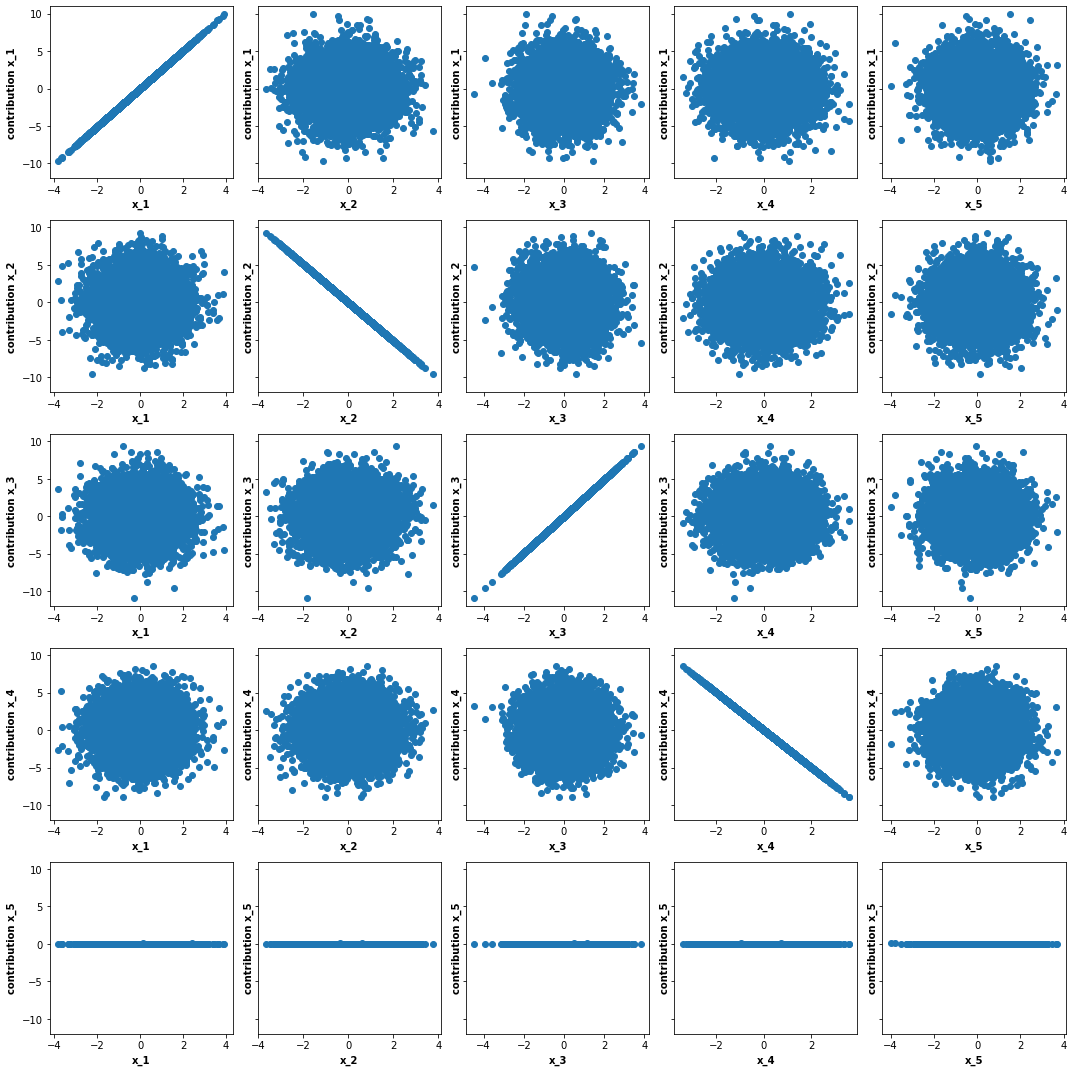

In [28]:
print(f"LR --RMSE perf = {rmse} -- r2 perf = {r2}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_lr[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

TabSRALinear --RMSE perf = 0.37512070997404334 -- r2 perf = 0.9972284455460778


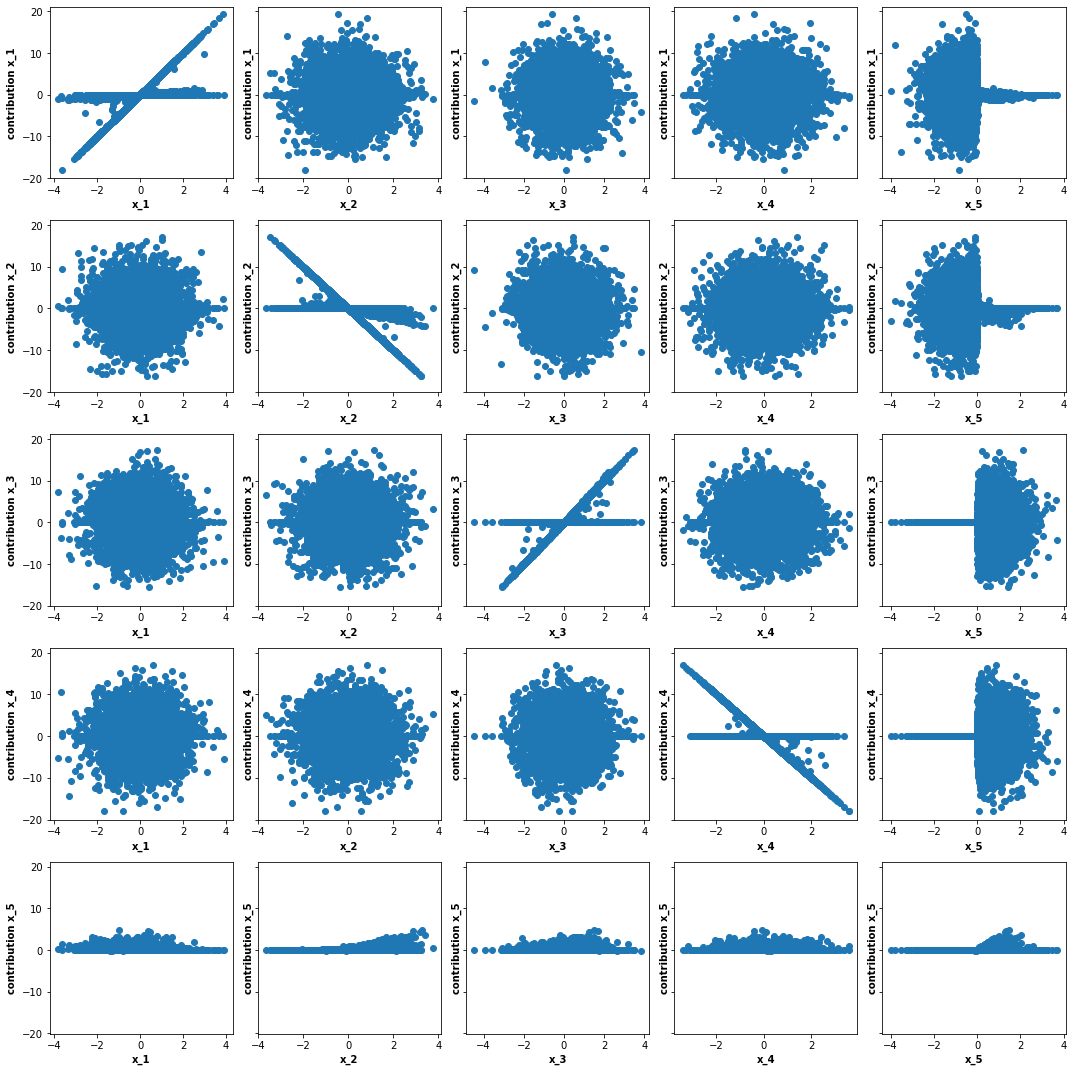

In [29]:
print(f"TabSRALinear --RMSE perf = {rmse_tabsra} -- r2 perf = {r2_tabsra}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_tabsra[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

XGBoost --RMSE perf = 0.3777988808188163 -- r2 perf = 0.9971887292986349


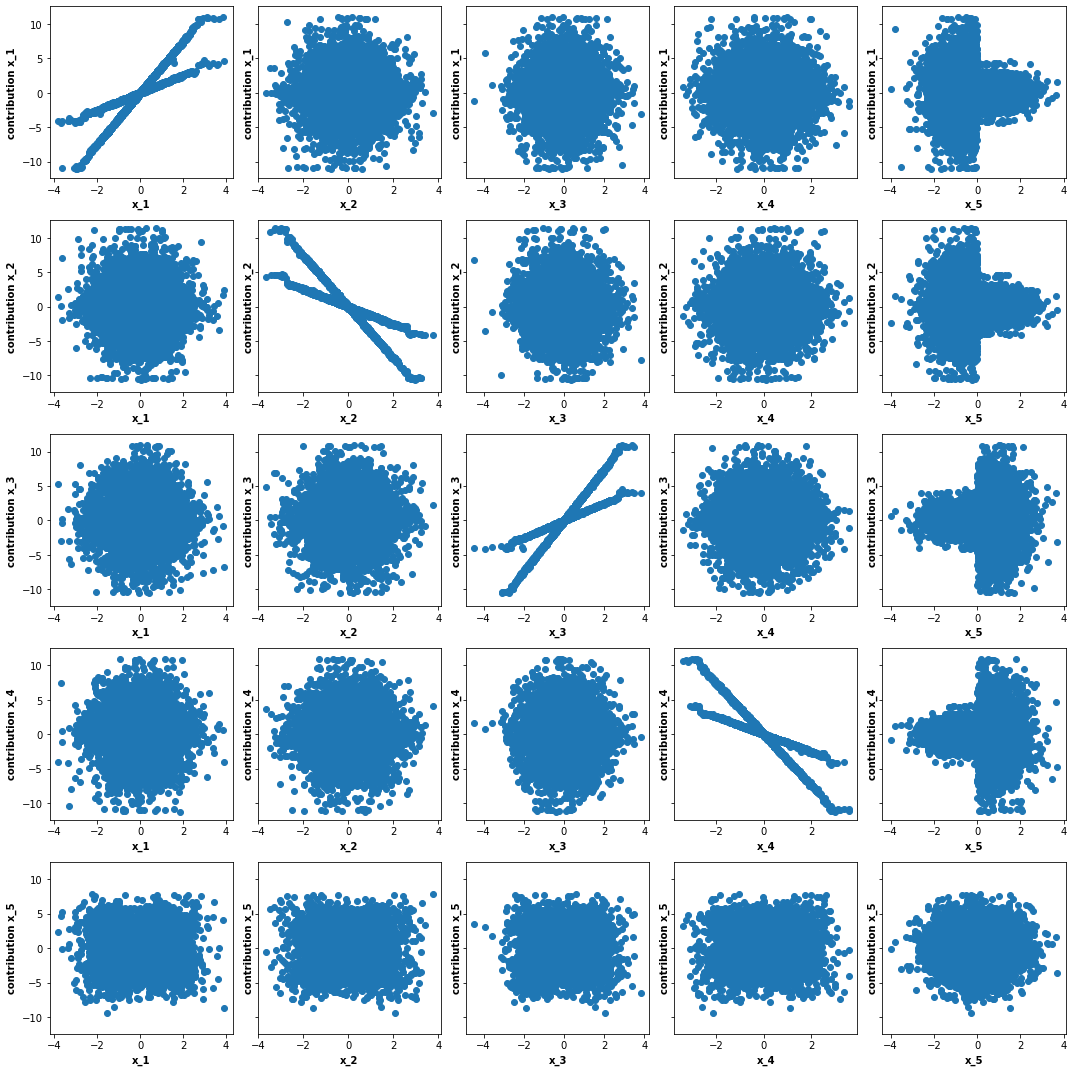

In [30]:
print(f"XGBoost --RMSE perf = {best_rmse_xgb} -- r2 perf = {best_r2_xgb}")
f, ax = plt.subplots(5, 5, sharey=True,figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(df_test[f"x{j+1}"], attributions_xgb[f"x{i+1}"]) 
        ax[i,j].set_xlabel(f"x_{j+1}",weight = 'bold')
        ax[i,j].set_ylabel(f"contribution x_{i+1}",weight = 'bold')
plt.tight_layout()
plt.show()

## Identification of important features

For this example, a perfect model should use only the features $x_1$ and $x_2$, or alternatively, depending on the sign of $x_5$, use the features $x_3$ and $x_4$.
We restrict our analysis to those data points with $x_5\le 0$. Therefore only $x_1$ and $x_2$ are relevant among $(x_1, x_2, x_3, x_4)$. 

In [31]:
### Add x5
attributions_lr['x5_raw'] = df_test["x5"]
attributions_tabsra['x5_raw'] = df_test["x5"]
attributions_xgb['x5_raw'] = df_test["x5"]

In [32]:
attributions_lr_tmp = attributions_lr[attributions_lr.x5_raw<0]
attributions_tabsra_tmp = attributions_tabsra[attributions_tabsra.x5_raw<0]
attributions_xgb_tmp = attributions_xgb[attributions_xgb.x5_raw<0]

In [33]:
### Two first features ('x1','x2') should have index (2,3) ie most important in absolute value
precision_lr = np.argsort(attributions_lr_tmp[['x1','x2','x3','x4']].abs()).apply(lambda x: len(set([2,3]).intersection(set(x[0:2]))),axis=1)
precision_lr.mean()/2

0.5114666666666666

In [34]:
precision_tabsra = np.argsort(attributions_tabsra_tmp[['x1','x2','x3','x4']].abs()).apply(lambda x: len(set([2,3]).intersection(set(x[0:2]))),axis=1)
precision_tabsra.mean()/2

0.9985333333333334

In [35]:
precision_xgb= np.argsort(attributions_xgb_tmp[['x1','x2','x3','x4']].abs()).apply(lambda x: len(set([2,3]).intersection(set(x[0:2]))),axis=1)
precision_xgb.mean()/2

0.7570666666666667

TabSRALinear can identify the two most important features with high precision **99.85%**